## Version SIGMOID-NOREG: 
- 44,100 Hz sample rate 
- NO regularization
- 300,000 iterations
- 0.95 learning rate decay
- sigmoid output function
- add a BIAS to output layer
- learning rete 0.005



### 0. Import the packages

In [75]:
import os,sys,shutil,mmap
import pickle as pickle
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting
from scipy.fftpack import fft

import time

sys.path.insert(0,'lib/')
import config

from sklearn.metrics import average_precision_score

import tensorflow as tf

import mir_eval

%matplotlib inline

notebook_reference = str(190314)

In [2]:
debugging = False
delete_ids = [2560, 1792, 2562, 2506, 2564, 2566, 1793, 2568, 2570, 2571, 2572, 2573, 2575, 2576, 2302, 2581, 2582, 
              2586, 2075, 2076, 2077, 2590, 2079, 2080, 2081, 2594, 2595, 2596, 2603, 2678, 2397, 2608, 2611, 2614, 
              2104, 2105, 2619, 2620, 2621, 2622, 2112, 2113, 2114, 2627, 2116, 2629, 2118, 2119, 2632, 2633, 2127, 
              2131, 2138, 2319, 2140, 2405, 2659, 2148, 2149, 2150, 2151, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 
              2161, 2677, 2166, 2167, 2168, 2169, 2239, 2325, 2177, 2178, 2179, 2180, 1729, 2186, 2242, 2194, 2195, 
              2196, 1829, 2198, 2200, 2201, 2202, 2203, 2204, 2330, 2207, 2208, 2209, 2210, 2211, 2212, 2213, 2214, 
              2215, 2588, 2218, 2219, 2220, 2221, 2222, 2224, 2225, 2227, 2228, 2229, 2230, 2231, 2232, 2234, 2591, 
              2237, 2238, 1727, 1728, 2241, 1730, 2243, 2244, 1733, 1734, 2593, 2248, 1739, 2240, 2082, 1742, 2083, 
              1749, 1750, 1751, 1752, 1755, 1756, 1757, 1758, 1760, 1763, 1764, 1765, 1766, 1768, 2282, 1771, 1772, 
              1773, 1775, 1776, 1777, 2292, 2293, 2294, 2295, 2296, 2297, 1919, 1788, 1789, 1790, 2304, 2305, 2307, 
              2308, 2310, 2313, 2314, 2315, 1805, 2318, 1807, 2320, 2322, 1811, 1812, 1813, 1817, 1818, 2334, 2335, 
              2336, 1828, 2341, 2342, 2343, 2567, 2345, 2346, 1835, 2348, 2350, 2491, 2357, 2358, 2359, 2364, 2365, 
              2366, 2368, 2371, 2372, 2373, 2374, 2529, 2376, 2377, 2379, 2443, 2381, 2383, 2384, 1873, 2388, 2389, 
              2390, 2391, 2392, 2393, 2618, 2398, 2403, 2404, 1893, 2406, 2410, 2411, 2415, 2417, 2147, 2451, 2420, 
              2422, 2423, 2424, 1916, 2538, 1918, 2431, 2432, 2433, 1922, 1923, 2436, 2441, 2442, 1931, 1932, 2626, 
              1735, 2285, 1859, 2247, 2117, 2288, 2466, 2444, 2289, 2472, 2473, 2476, 2477, 2478, 2480, 2481, 2482, 
              2483, 2462, 2486, 2487, 2488, 2490, 2463, 2492, 2494, 2555, 2497, 1822, 2501, 2502, 2504, 2505, 2078, 2507]

### 1. Import the data
Import the recording and labels of the 331 recordings from the data base.

#### 1.1 Import the labels of the data set.
The 331 labels are saved in a dictionary whose
- keys are integers (the ids of the recordings)
- values are intervaltrees (for the different intervals of the recording it gives the played notes between 1 and 128)

In [3]:
with open(config.labels_path, 'rb') as f:
    labels = pickle.load(f)

In [4]:
print(len(labels), 'labels')

331 labels


In [5]:
for key, value in labels.items() :
    if key == 2239:
        # id of the recording
        print (key)
        # intervaltree containing for each note intervals in which it is played
        print (type(value))

2239
<class 'intervaltree.intervaltree.IntervalTree'>


#### 1.2 Import recordings

Create a dictionary containing the data (recordings). Use Memory-mapped file objects.
For each recording data[rec_id] is a tuple:
1. data[rec_id][0] is the memory-mapped file object to the recording. It can be accesed by 
~~~~~~
np.frombuffer(data[rec_id][0], dtype=np.float32).copy()
~~~~~~
2. data[rec_id][1] is its length (float)

In [6]:
sz_float = 4

In [7]:
data = dict()
for record in os.listdir(config.records_path):
    fd = os.open(config.records_path + record, os.O_RDONLY)
    buff = mmap.mmap(fd, 0, mmap.MAP_SHARED, mmap.PROT_READ)
    data[int(record[:-4])] = (buff, len(buff)/sz_float)
    os.close(fd)

In [28]:
for key, value in data.items() :
    if key == 2494:
        # id of the recording
        print ('Key:',key,', Format:',type(key))
        # its value is a tuple
        print ('Value:',value)
        # 1. value: reference to recording
        print ("1. Entry: Memory-mapped file objects ,", data[2239][0])
        # to access content use:
        x = np.frombuffer(data[2239][0], dtype=np.float32).copy()
        print('For example:')
        print(x[3005:3017])
        print ("2. Entry: length of recording",str(data[2239][1]),", Type:",type(data[2239][1]))
        #print(len(x))

Key: 2494 , Format: <class 'int'>
Value: (<mmap.mmap object at 0x7f11a245c228>, 13100544.0)
1. Entry: Memory-mapped file objects , <mmap.mmap object at 0x7f11a24575d0>
For example:
[ 0.00036621  0.00039673  0.00036621  0.00036621  0.00033569  0.00033569
  0.00036621  0.00036621  0.00036621  0.00033569  0.00036621  0.00039673]
2. Entry: length of recording 5293440.0 , Type: <class 'float'>


#### 1.3 Split up in the test and train set

In [29]:
extended_test_set = True
use_mirex = True
    
# use the small or big test set
if extended_test_set:
    test_ids = config.test_ids_ext
else:
    test_ids = config.test_ids

# include the mirex dev set in test results
if use_mirex:
    test_ids = test_ids + config.mirex_id

train_ids = [rec_id for rec_id in labels.keys() if rec_id not in test_ids]

if debugging == True:
    train_ids = [rec_id for rec_id in train_ids if rec_id not in delete_ids]


print('There are {} samples in the test set'.format(len(test_ids)))
print('There are {} samples in the train set'.format(len(train_ids)))

There are 11 samples in the test set
There are 320 samples in the train set


### 2. Preprocessing

The input data (recordings) are normalized and the possible note range is defines to 128 notes. The lowest note is ..., the highest ... .

In [30]:
# Normalize the recordings
normalize = True
# Possible notes are from range [base_note, base_note + m)
base_note = 0
mm = 128

#### 2.1 Data augmentation

Always make two small changes to input data by randomly stretching or shrinking our input audio that are not noticable by human hearing, but augment the data set:
1. Pitch-shift in the frequency domain: Randomly  shifting  each data points in a minibatch by an integral number of semitones. This reinforces the architectural structure of the translation-invariant network.
2. Jittering: continuous shift to each data point. This makes the models more robust to tuning variation between recordings --> regularization

Define a function for extracting a sequence and its label as well as applying the data augmentation.

In [31]:
# pitching: stretching or shrinking our input audio with linear interpolation
pitch_transforms=5 # =/- 5 semitones
jitter=.1

Pitch-shifting corresponds to a multiplication by $2^{1/12}$ (an octave is equal to 12 semitones and corresponds to a factor 2 in the frequency domain) for each semirone.

A scaling factor in the frequency domain implies also a scaling factor in the time domain. (speeding up the recording $\to$ higher frequency $\to$ sounds higher.


In [32]:
# function to obtain one data sample from recordings
# input:
# - rec_id: the id of the recording
# - s: frame-number to extract
# - window: windowsize
# - pitchshift: shift the label by pitchshift halftones
# - scaling_factor: scaling factor in frequency domain (includes corrections because of pitch shift and jitter)
# - normalize: boolean
# output
# - x: audio segment of length window
# - y: labels, 0-1-vector of length mm
def get_data(rec_id,s,window,pitch_shift,scaling_factor, normalize=True):
   
    x = np.frombuffer(data[rec_id][0][s*sz_float:int(
        s+scaling_factor*window)*sz_float], dtype=np.float32).copy()
    
    if normalize: 
        x /= np.linalg.norm(x) + config.epsilon

    xp = np.arange(window,dtype=np.float32)
    # interpolate the discrete function (np.arange(len(x)), x) at the points (scaling_factor*xp)
    x = np.interp(scaling_factor*xp,np.arange(len(x),dtype=np.float32),x).astype(np.float32)
    # real-valued audio frame with values in the range [−1,1], sampled at 44.1 kHz
    # -> x has length window
    
    y = np.zeros(mm)
    # select center of frame
    for label in labels[rec_id][s+scaling_factor*window/2]:
        y[label.data[1]+pitch_shift-base_note] = 1 # apply pitch shift here (in frequency domain)
    
    return x,y

#### 2.1 Batch-selection
Create the training batch applying the above explained methods for Data augmentation

In [33]:
# function to create an input batch for one training step
# input:
# - model_stats: model_results-class containing training_ids
# - batch_size (integer)
# - window: window-length
# - pitch_transforms: integer in [-5,5], number of maximum semitones shifted
# - jitter: float in [-0.1,0.1], tuning variation
# output:
# - xmb: batch for a training step, size: (batch_size,1,window,1)
# - ymb: corresponding labels to the batch xmb, size: (batch_size,1,mm)
def get_training_batch(model_stats, batch_size, window, pitch_transforms=0, jitter=0):
    # arrays for input data (batch)
    xmbatch = np.empty([batch_size,1,window,1],dtype=np.float32)
    ymbatch = np.empty([batch_size,1,mm],dtype=np.float32)
        
    # picking randomly batch_size recordings
    rec_ids = [model_stats.train_ids[r] for r in \
               np.random.randint(0,len(model_stats.train_ids),batch_size)]
        
    if pitch_transforms > 0:
        transform_type = np.random.randint(-pitch_transforms,
                                           pitch_transforms,batch_size)

    if jitter > 0:
        jitter_amount = np.random.uniform(-jitter,jitter,batch_size)

    for i in range(batch_size):
        scaling_factor = 1
        shift = 0
        if pitch_transforms > 0:
            shift = transform_type[i]
            # half-step has a frequency ratio of 2^(1/12)
            # (shift + jitter_amount) halfsteps are shifted
            if jitter > 0:
                scaling_factor = (2.**((shift+jitter_amount[i])/12.))
            else:
                # only shift the halftones from pitch_transform
                scaling_factor = (2.**(shift/12.))
        
        # multiply in frequency domain by scaling_factor
        
        # pick a frame for training randomly
        s = np.random.randint(0,data[rec_ids[i]][1]-scaling_factor*window)
        xmbatch[i,0,:,0],ymbatch[i,0,:] = get_data(rec_ids[i],s,window,pitch_shift=shift,scaling_factor=scaling_factor)
        
    return xmbatch, ymbatch

#### 2.3 Creation of Training and Test set for protocolling

Routines that create sample for the protcoling:
1. Routine to obtain the training samples from numpy-file.
2. Routine to obtain test samples given the recording IDs of the test samples.

In [34]:

# function to obtain training sample which is already saved in 
# numpy fromat in file. only normalization is necessary.
# input:
# - d: window size (integer)
# - normalize: boolean
# output:
# - Xtrain: training sample of size (15000, 1, d, 1)
# - Ytrain: corresponding labels of size (15000, 128)
def get_training_sample(d=16384, normalize=True):
    cachex = config.tmp + 'Xtrain_ext{}.npy'.format(d)
    cachey = config.tmp + 'Ytrain_ext{}.npy'.format(d)
    #shape Xtrain: (15000, 1, 16384, 1)
    #shape Ytrain: (15000, 128)
    if os.path.exists(cachex) and os.path.exists(cachey):
        Xtrain = np.load(cachex)
        Ytrain = np.load(cachey)
    else:
        print(cachex)
        print(cachey)
        raise Exception('Unimplemented')

    if normalize:
        Xtrain = Xtrain.reshape(len(Xtrain),1,d,1)
        for i in range(len(Xtrain)):
            Xtrain[i] /= np.linalg.norm(Xtrain[i]) + config.epsilon

    return Xtrain,Ytrain


# function to obtain test sample using get_data(). every sample is split 
# up in count sequences.
# input:
# - rec_ids: ids of test samples
# - window: size of the input frame
# - count: number of sequences to be created for each sample
# - fixed_stride: -1 (stride is adapted to sample) or nonnegative integer
# - pitch_shift: value by which recording is stretched or shrinked
# output:
# - Xtest: test sample of size (count*len(rec_ids),1,window,1)
# - Ytest: corresponding labels of size (count*len(rec_ids),mm)
def get_test_sample(rec_ids, window, count, fixed_stride=-1, pitch_shift=0):
    Xtest = np.zeros([count*len(rec_ids),1,window,1])
    Ytest = np.zeros([count*len(rec_ids),mm])
    offset = 44100
    # calculate scaling factor
    sf = 2.**(pitch_shift/12.)
    # for every sample create 1000 sequences
    for i in range(len(rec_ids)):
        X = np.zeros([count,1,window,1])
        Y = np.zeros([count,mm])
        # calculate teh stride in case it is not fixed
        stride = (data[rec_ids[i]][1]-offset-int(sf*window))/count if fixed_stride==-1 else fixed_stride
        for j in range(count):
            X[j,0,:,0],Y[j] = get_data(rec_ids[i],int(offset+j*stride),window,pitch_shift=int(round(pitch_shift)),scaling_factor=sf)
        
        Xtest[i*count:(i+1)*count] = X
        Ytest[i*count:(i+1)*count] = Y
    return Xtest, Ytest

Save the results, losses, precicions and weights at each protocol point inside a class.

In [48]:
class model_results():
    def __init__(self, test_ids, train_ids):
        # weights
        self.weights = dict()
        # step
        self.iter = 0
        # result statistics
        self.stats = dict()
        self.stats['iter'] = [False,'{:<8}',[]]
        # time that has passed since last record
        self.stats['time'] = [True,'{:<8.0f}',[]]
        self.stats['lr'] = [False,'{:<8.6f}',[]]
        # mean squared errors
        self.stats['mse_train_1'] = [True,'{:<16.6f}',[]]
        self.stats['mse_train'] = [True,'{:<16.6f}',[]]
        self.stats['mse_test'] = [True,'{:<16.6f}',[]]
        # precicions
        self.stats['avp_train'] = [True,'{:<16.6f}',[]]
        self.stats['avp_test'] = [True,'{:<16.6f}',[]]
        
        self.averages = []
        
        self.test_ids = test_ids
        self.train_ids = train_ids

    # Register the weights inside the list w_list. 
    # The list name_list contains the corresponding names of the wariables in w_list
    def register_weights(self, w_list, name_list):
        if len(w_list) != len(name_list):
            print("error: input lists need to have same length")
            
        for ii in range(len(w_list)):
            w = w_list[ii]
            name = name_list[ii]
            # register the norm of the weights
            self.stats['n'+name] = [False,'{:<8.3f}',[]] 
            # register the weights
            self.weights[name] = w
            
        return None
        
model_stats = model_results(test_ids, train_ids)


### 4. Error measures
Define the error measures for comparing the correct labeling Y with the extimated labeling Y_hat.
Both labelings are of size (mm) for each segment. The errors are calculated at each protocol point for the training and the test set.
1. Mean Squared Error: When applying the model to a sequence or sequences the mean squared error is calculated directly by applying the tensorflow function.
~~~~~~~~~~~~~~~~~~~~~
tf.reduce_mean(tf.nn.l2_loss( Y_hat - Y ))
~~~~~~~~~~~~~~~~~~~~~
2. Average Precision: The average precision is calculated with the metric function from the sklear package.
~~~~~~~~~~~~~~~~~~~~~
sklearn.metrics.average_precision_score
~~~~~~~~~~~~~~~~~~~~~


### 5. Define the graph

Define batch size (batch_size segments at each training step). Also define a small factor wscale to scale the weights. Regularization can be avoided.

In [49]:
batch_size=150
if debugging == True:
    batch_size = 4
out = 1

#### 5.1 Define layers

#### First layer: 

Lenth of the input (segment) is window=16384. Compute a strided convolution with a d=4096-sample recptive field and a stride=512 sample stride. Since every segment has 16384 samples there are 25 regions for each frame.

After the convolution for each region a filterbank computation is calculated. 
As a filter a log=spaced filterbank is chosen (k=512 sine and cosine filters with logarithmically spaced frequencies from 50 hz to 6000 hz) which is going to be applied to all the regions of the convolution of size d=4096

In [50]:
# variables for input layer

# input size of segment, predict notes played at midpoint of segment
window=16384
# size of regions that outputs the convolution from layer one (receptive field)
dd = 4096
#stride for first layer convolution
stride=512
# --> 25 regions

# variables for filterbank (= first layer)
# number of nodes in first layer (by filterbank get from dd nodes to kk nodes)
kk = 512 

In [51]:
def create_filters(d,k):
    # create k filters
    # d is the length of the receptive field (input)
    x = np.linspace(0, 2*np.pi, d, endpoint=False)
    wsin = np.empty((1,d,1,k), dtype=np.float32)
    wcos = np.empty((1,d,1,k), dtype=np.float32)
    start_freq = 50.
    end_freq = 6000.
    num_cycles = start_freq*d/44100.                                          
    scaling_ind = np.log(end_freq/start_freq)/k
    window_mask = 1.0-1.0*np.cos(x)
    for ind in range(k):
        wsin[0,:,0,ind] = window_mask*np.sin(np.exp(ind*scaling_ind)*num_cycles*x)
        wcos[0,:,0,ind] = window_mask*np.cos(np.exp(ind*scaling_ind)*num_cycles*x)
            
    return wsin,wcos

#### Second layer:

In [52]:
# variables for second layer
d2_x = 1          # lvl2 input dims_x
d2_y = 128          # lvl2 input dims_y
k2 = 128        # num lvl2 filters
stride_y = 2    # lvl2 stride

#### Third layer:

In [53]:
# variables for third layer
d3_x = 25 # lvl3 input dims_x
d3_y = 1 # lvl3 input dims_y (fully connected)
k3 = 4096 # num lvl3 filters

Calculate the sizes of nodes at each layer

In [54]:
num_regions  = int(1 + (window-dd)/stride)
print ('First layer regions: ({},{})'.format(num_regions,kk))
num_regions2_x  = int(1 + (num_regions-d2_x)/1)
num_regions2_y = int(1 + (kk-d2_y)/stride_y)
print ('Second layer regions: ({},{})'.format(num_regions2_x,num_regions2_y))
num_regions3_x = int(1 + (num_regions2_x - d3_x)/1)
num_regions3_y = int(1 + (num_regions2_y - d3_y)/1)
print ('Third layer regions: ({},{})'.format(num_regions3_x,num_regions3_y))

# create filters (shape: (1, 4096, 1, 512)) = number of regions x size of region
wsin,wcos = create_filters(dd,kk)

First layer regions: (25,512)
Second layer regions: (25,193)
Third layer regions: (1,193)


#### 5.2 Define tf.Graph()
Set it all together and define the graph.

For evaluation not the trained weights, but its moving averages with decay 0.9998 are utilized. The shadow variables are maintained by tf.train.ExponentialMovingAverage. In the block for evaluating the direct model their values are retrieved.

In [55]:
tf.set_random_seed(999)

#end_learning_rate = .00001/3/3/3
starter_learning_rate = .005
mom = .95

beta_reg = 0.0

graph = tf.Graph()

with graph.as_default():
     
    # if the input is a batch
    with tf.variable_scope('data_queue'):
        xb = tf.placeholder(tf.float32, shape=[None, 1, window+(out-1)*stride, 1])
        yb = tf.placeholder(tf.float32, shape=[None, out, mm])

        xq, yq = xb, yb
        
    # if the input is just one segment
    with tf.variable_scope('direct_data'):
        xd = tf.placeholder(tf.float32, shape=[None,1,window,1])
        yd = tf.placeholder(tf.float32, shape=[None, mm])
    
    print ('---- Weights ----')
    with tf.variable_scope('parameters'): #glorot  
        w = tf.get_variable('w', [d2_x,d2_y,1,k2]) # 1 x 128 x 1 x 128 (16.384 values)
        print ('w',w)
        w2 = tf.get_variable('w2', [d3_x,d3_y,k2,k3]) # 25 x 1 x 128 x 4096 (13.107.200 values)
        print ('w2',w2)
        beta = tf.get_variable('beta', [int(num_regions3_x*num_regions3_y*k3)+1,mm]) 
        # (1*193*4096+1) x 128 (101.187.584 + 128 values) BIAS!!
        print ('beta',beta)
        model_stats.register_weights([w,w2,beta],['w','w2','beta'])

    print ('---- Layers ----')
    with tf.variable_scope('queued_model'):
        zx = tf.square(tf.nn.conv2d(xq,wsin,strides=[1,1,stride,1],padding='VALID')) \
           + tf.square(tf.nn.conv2d(xq,wcos,strides=[1,1,stride,1],padding='VALID'))
        print ('zx',zx)
        z2 = tf.nn.relu(tf.nn.conv2d(tf.log(zx+10e-15),w,strides=[1,1,1,stride_y],padding='VALID',data_format='NCHW'))
        print ('z2',z2)
        z3 = tf.nn.relu(tf.nn.conv2d(z2,w2,strides=[1,1,1,1],padding='VALID',data_format='NCHW'))
        print ('z3',z3)
        y = tf.matmul(
            tf.concat([tf.reshape(z3,[batch_size,int(num_regions3_x*num_regions3_y*k3)]),
                      tf.ones([batch_size,1], tf.float32)],1),beta)
        print ('y',y)
        #loss = tf.reduce_mean(tf.nn.l2_loss(y-tf.reshape(yq,[batch_size,mm])))
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.reshape(yq,[batch_size,mm]), logits=y) 
        print ('loss',loss)
            
    # learning rate decay
    global_step = tf.Variable(0, trainable=False)
    lr = tf.train.exponential_decay(starter_learning_rate, global_step, 10000, 0.95, staircase=True)

    reg = tf.nn.l2_loss(w) + tf.nn.l2_loss(w2) + tf.nn.l2_loss(beta)
    
    #opt_op = tf.train.MomentumOptimizer(lr,mom).minimize(tf.reduce_mean(loss + beta_reg*reg), global_step=global_step)
    
    opt_op = tf.train.MomentumOptimizer(lr,mom).minimize(tf.reduce_mean(loss), global_step=global_step)

    
    # Create an ExponentialMovingAverage object
    ema = tf.train.ExponentialMovingAverage(decay=0.9998)
    
    with tf.control_dependencies([opt_op]):
        training_op = ema.apply([w, w2, beta])
    
    with tf.variable_scope('direct_model'):
        # use ema.average(var) to return the average of variable var
        wavg = ema.average(w)
        w2avg = ema.average(w2)
        betaavg = ema.average(beta)

        direct_zx = tf.square(tf.nn.conv2d(xd,wsin,strides=[1,1,stride,1],padding='VALID')) \
                + tf.square(tf.nn.conv2d(xd,wcos,strides=[1,1,stride,1],padding='VALID'))
        direct_z2 = tf.nn.relu(tf.nn.conv2d(tf.log(direct_zx+10e-15),wavg,strides=[1,1,1,stride_y],padding='VALID',data_format='NCHW'))
        direct_z3 = tf.nn.relu(tf.nn.conv2d(direct_z2,w2avg,strides=[1,1,1,1],padding='VALID',data_format='NCHW'))
        direct_y = tf.nn.sigmoid(tf.matmul(
            tf.concat([tf.reshape(direct_z3,[tf.shape(xd)[0],int(num_regions3_x*num_regions3_y*k3)]),
                     tf.ones([tf.shape(xd)[0],1], tf.float32)],1),betaavg))
        direct_loss = tf.reduce_mean(tf.nn.l2_loss(direct_y-yd))
        

---- Weights ----
w <tf.Variable 'parameters/w:0' shape=(1, 128, 1, 128) dtype=float32_ref>
w2 <tf.Variable 'parameters/w2:0' shape=(25, 1, 128, 4096) dtype=float32_ref>
beta <tf.Variable 'parameters/beta:0' shape=(790529, 128) dtype=float32_ref>
---- Layers ----
zx Tensor("queued_model/add:0", shape=(?, 1, 25, 512), dtype=float32)
z2 Tensor("queued_model/Relu:0", shape=(?, 128, 25, 193), dtype=float32)
z3 Tensor("queued_model/Relu_1:0", shape=(?, 4096, 1, 193), dtype=float32)
y Tensor("queued_model/MatMul:0", shape=(150, 128), dtype=float32)
loss Tensor("queued_model/logistic_loss:0", shape=(150, 128), dtype=float32)


#### 5.3 Evaluation of the graph

For the aplication of the neuronal network a moving average of the weights is used. Therefore, a different function for evaluation is used.

Inside the function predict_direct_model the mean squared error is calculated directly.

In [56]:
# function for prediction without training that splits up the whole set
# in small subsets to prevent errors of type "ResourceExhaustedError"
# input: 
# - sess: the actual session
# - X: sample, size: (n,1,window,1)
# - Y: corresponding labels, size: (n,mm)
# output:
#  Yhat: prediction, size: (n,mm)
#  mse: Mean Squared Error when comparing Y and Yhat
def predict_direct_model(sess, X, Y):
    Yhat = np.empty((len(X),mm))
    subdiv = 100
    subset = X.shape[0]/subdiv
    mse = 0
    for j in range(subdiv):
        Yhat[int(subset*j):int(subset*(j+1))], se = sess.run([direct_y,direct_loss], 
                                                         feed_dict={xd: X[int(subset*j):int(subset*(j+1))],
                                                                    yd: Y[int(subset*j):int(subset*(j+1))]})
        mse += se

    return Yhat, mse/float(subdiv)

### 6. Training

In [57]:
if debugging == True:
    num_steps = 5
    control_step = 1
else:
    num_steps = 300000
    control_step = 1000

gpu_memory_growth = False

In [58]:
# arrays for input data (batch)
xmb = np.empty([batch_size,1,window,1],dtype=np.float32)
ymb = np.empty([batch_size,1,mm],dtype=np.float32)

In [59]:
# train saver
saver = tf.train.Saver({'wavg': wavg, 'w2avg': w2avg, 'betaavg': betaavg})

In [60]:
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    ptime = time.time()
    tfconfig = tf.ConfigProto()
    tfconfig.gpu_options.allow_growth=gpu_memory_growth
    init_op = tf.global_variables_initializer()    
    sess = tf.Session(config=tfconfig)
    sess.run(init_op)
    print ('iter\t test_squ_loss\t test_avg_prec\t',
           'train_squ_loss\t train_avg_prec\t regularization\t time (in s)')
    for step in range(num_steps):        
        #print('Step',step)
        #print('There are {} samples in the test set'.format(len(model_stats.test_ids)))
        #print('There are {} samples in the train set'.format(len(model_stats.train_ids)))
       
        xmb, ymb = get_training_batch(model_stats, batch_size, window, 
                                      pitch_transforms, jitter)
        
        # every 1000-nd step save the results           
        if step%control_step==0:
            # training step 
            # to check output the loss (save the loss but you cannot compare it with the mse_train)
            _, np_loss, np_global_step, np_lr, reg_np = \
            sess.run([training_op, loss, global_step, lr, reg], 
                                     feed_dict={xb: xmb, yb: ymb})
            
            # A) run model on test set
                        
            # 1. get the test set
            X,Y = get_test_sample(model_stats.test_ids, window, 1000)
            Y = Y[:,base_note:base_note+mm] # in general without effect
            # shape Xtest: (1000*len(test_ids), 1, 16384, 1)
            # shape Ytest: (1000*len(test_ids), 128)
            # extended test-set: 11 samples

            
            # 2. prediction of output and calculation of
            # - MSE
            # - average precision
            Y_p, mse_test = predict_direct_model(sess, X, Y)
            avp_test = average_precision_score(Y.flatten(), Y_p.flatten())
            
            del X,Y,Y_p
            
            # B) run model on training set
            
            # 1. get training sample
            X,Y = get_training_sample(window)
            Y = Y[:,base_note:base_note+mm] # in general without effect
            # shape Xtrain: (15000, 1, 16384, 1)
            # shape Ytrain: (15000, 128)
            
            # 2. prediction of output and calculation of
            # - MSE
            # - average precision
            Y_p, mse_train = predict_direct_model(sess, X, Y)
            avp_train = average_precision_score(Y.flatten(), Y_p.flatten())
            
            del X,Y,Y_p
            
            # c) Print the temporary results
            print (np_global_step,'\t', round(mse_test,8),
                    '\t', round(avp_test,8),
                    '\t', round(mse_train,8),
                    '\t', round(avp_train,8),
                    '\t', round(reg_np,8),
                    '\t', round(time.time() - ptime,8))
            
            #D) Save the temporary results
            model_stats.stats['iter'][2].append(np_global_step)
            # protocol learning rate
            model_stats.stats['lr'][2].append(np_lr)
            # protocol runtime
            model_stats.stats['time'][2].append(time.time() - ptime)
            # protocol weights and its norms
            weight_norms = dict()
            for name, w in model_stats.weights.items():
                weight_norms[name] = np.mean(np.linalg.norm(w.eval(session=sess),axis=0))
            for name, norm in weight_norms.items():
                model_stats.stats['n'+name][2].append(norm)
            # protocol training errors     
            track = []
            model_stats.stats['mse_train_1'][2].append(np_loss)
            model_stats.stats['mse_train'][2].append(mse_train)
            track += [tf.summary.scalar('mse_train', mse_train)]
            model_stats.stats['avp_train'][2].append(avp_train)
            track += [tf.summary.scalar('avp_train', avp_train)]
            # protocol test errors
            model_stats.stats['mse_test'][2].append(mse_test)
            track += [tf.summary.scalar('mse_test', mse_test)]
            model_stats.stats['avp_test'][2].append(avp_test)
            track += [tf.summary.scalar('avp_test', avp_test)]
            ptime = time.time()
            
                   
        else:
            #training step 
            sess.run([training_op], feed_dict={xb: xmb, yb: ymb})
        
        if step/num_steps==0.5 or (step+1)/num_steps==1:
            saver.save(sess, 'models_'+notebook_reference+'/model', global_step=step)            
        
    print ('\nTRAINING DONE')

Initialized
iter	 test_squ_loss	 test_avg_prec	 train_squ_loss	 train_avg_prec	 regularization	 time (in s)
1 	 1774.52914307 	 0.01498712 	 2416.64270508 	 0.01848589 	 253.081 	 33.02560878
1001 	 578.23144928 	 0.30070088 	 842.30477356 	 0.33441585 	 255.605 	 539.47744656
2001 	 274.99009262 	 0.51037048 	 415.84526978 	 0.53977823 	 256.26 	 539.64069295
3001 	 166.65559174 	 0.58904409 	 257.69496399 	 0.60996324 	 256.769 	 540.547086
4001 	 117.08202866 	 0.62653261 	 184.68053101 	 0.64098866 	 257.225 	 540.39966464
5001 	 92.53661472 	 0.64850733 	 148.56236099 	 0.65818463 	 257.666 	 540.74291611
6001 	 79.80252346 	 0.66259854 	 129.90293915 	 0.66924019 	 258.092 	 539.92923379
7001 	 72.7537734 	 0.6728635 	 119.68309624 	 0.67703952 	 258.491 	 539.64271832
8001 	 68.66226709 	 0.6800237 	 113.77709145 	 0.68285832 	 258.89 	 540.57047725
9001 	 66.10314537 	 0.68578882 	 110.13908272 	 0.68755093 	 259.276 	 541.15296125
10001 	 64.42218225 	 0.69035438 	 107.7696493

96001 	 53.93884791 	 0.75711118 	 89.42696259 	 0.76488715 	 282.037 	 542.72797942
97001 	 53.92445641 	 0.75712161 	 89.34864563 	 0.76521107 	 282.241 	 543.367239
98001 	 53.92228288 	 0.75698285 	 89.27488953 	 0.76549912 	 282.456 	 543.83230114
99001 	 53.91007485 	 0.75704587 	 89.19512329 	 0.76580248 	 282.664 	 543.25806022
100001 	 53.91439196 	 0.75699625 	 89.12168991 	 0.76614486 	 282.866 	 543.61598444
101001 	 53.89024576 	 0.7570456 	 89.04675453 	 0.76649416 	 283.062 	 543.75285077
102001 	 53.88730269 	 0.75703264 	 88.97792404 	 0.76679335 	 283.25 	 544.53056288
103001 	 53.87390511 	 0.75719776 	 88.91288391 	 0.76709974 	 283.448 	 543.85879254
104001 	 53.84498598 	 0.75751179 	 88.84247406 	 0.76740011 	 283.641 	 543.54112339
105001 	 53.81261708 	 0.75769326 	 88.77803246 	 0.76769923 	 283.841 	 543.92980742
106001 	 53.77793971 	 0.75796432 	 88.71398163 	 0.76796274 	 284.038 	 544.009197
107001 	 53.76585995 	 0.75811677 	 88.65605141 	 0.76820133 	 2

193001 	 52.50549292 	 0.76717559 	 84.6801757 	 0.78558207 	 297.84 	 545.73823476
194001 	 52.50354667 	 0.76712394 	 84.64663811 	 0.7857553 	 297.962 	 545.56683612
195001 	 52.49135493 	 0.76725681 	 84.61023705 	 0.7859513 	 298.087 	 545.65556455
196001 	 52.50268991 	 0.76726516 	 84.58877968 	 0.78606543 	 298.211 	 543.93644834
197001 	 52.48839072 	 0.76747873 	 84.56082962 	 0.78619573 	 298.34 	 544.36750484
198001 	 52.47195947 	 0.76772294 	 84.5284407 	 0.78632505 	 298.468 	 546.60080934
199001 	 52.44718534 	 0.76799188 	 84.49225288 	 0.7864379 	 298.591 	 544.74734259
200001 	 52.45407136 	 0.76799541 	 84.45696152 	 0.78661387 	 298.714 	 543.73006058
201001 	 52.45497668 	 0.76798376 	 84.42780228 	 0.78675623 	 298.84 	 545.07489347
202001 	 52.45970142 	 0.7679161 	 84.39693649 	 0.7868847 	 298.958 	 546.934582
203001 	 52.45579891 	 0.76794991 	 84.35802055 	 0.78701763 	 299.08 	 544.13563418
204001 	 52.457171 	 0.76795291 	 84.33637154 	 0.78715281 	 299.2 

290001 	 52.14327092 	 0.76931919 	 82.20002213 	 0.79621456 	 307.711 	 552.25188303
291001 	 52.13030952 	 0.76938447 	 82.17811432 	 0.79631236 	 307.787 	 552.51575136
292001 	 52.11388554 	 0.76946612 	 82.15575478 	 0.7964117 	 307.867 	 549.1782186
293001 	 52.11423985 	 0.7694318 	 82.13356018 	 0.79651815 	 307.943 	 549.82873058
294001 	 52.11190169 	 0.7694991 	 82.11470734 	 0.79660096 	 308.021 	 548.69490504
295001 	 52.12566043 	 0.76950067 	 82.09516319 	 0.79668718 	 308.099 	 548.55338788
296001 	 52.12222643 	 0.76962583 	 82.08033104 	 0.79670093 	 308.178 	 550.2971735
297001 	 52.13036561 	 0.76956032 	 82.05902252 	 0.79680362 	 308.257 	 547.90722537
298001 	 52.14432141 	 0.76944742 	 82.03444244 	 0.79692766 	 308.335 	 549.46138787
299001 	 52.15547127 	 0.76935897 	 82.00892288 	 0.79701882 	 308.412 	 548.15608764

TRAINING DONE


In [61]:
X,Y = get_test_sample(model_stats.test_ids, window, 1000)
Y = Y[:,base_note:base_note+mm] # in general without effect
# shape Xtest: (1000*len(test_ids), 1, 16384, 1)
# shape Ytest: (1000*len(test_ids), 128)
# extended test-set: 11 samples


# 2. prediction of output and calculation of
# - MSE
# - average precision
Y_p, mse_test = predict_direct_model(sess, X, Y)

### 7. Post Processing

Define functions to save the model_results diccionary to a file and load it.

In [62]:
# in case diccionary should be printed
def print_dict(dictionary):
    for key, value in  dictionary.items():
        print (key)
        print (value)
#print_dict(model_stats.stats)
    
#save diccionary
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

# load diccionary
def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)


#### 7.1 Plots

In [63]:
# save diccionary to have a look at outputs at other times
save_obj(model_stats.stats, 'results/'+notebook_reference+'_stats')

In [68]:
results_stats = load_obj('results/'+notebook_reference+'_stats')

# size of plots
width = 20
height = 13
fontsize = 24
control_step = 1000

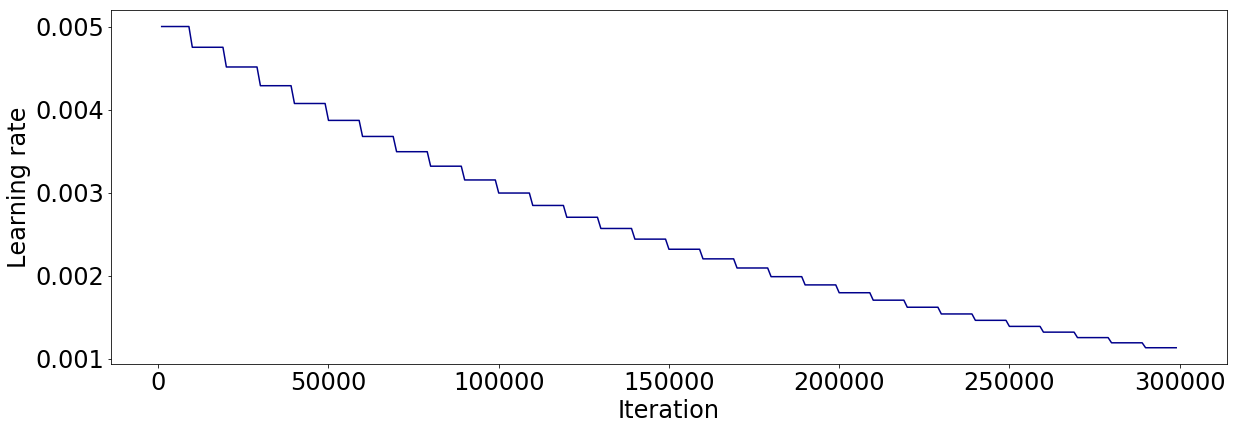

In [69]:
iters_res = results_stats['iter'][2]
time_res = results_stats['time'][2]
lr_res = results_stats['lr'][2]

plt.figure(figsize=(width, height/2))
plt.rcParams['xtick.labelsize']=fontsize
plt.rcParams['ytick.labelsize']=fontsize
#plot time needed for 'control_step' steps
"""
plt.subplot(2, 1, 1)
plt.title('Runtime and Learning Rate')
plt.plot(iters_res[1:], time_res[1:], c="darkblue")
plt.ylabel('Runtime of last '+str(control_step)+' steps (sec)')
plt.ylim( (0.9*np.min(time_res[1:]), 1.1*np.max(time_res[1:])))

plt.subplot(2, 1, 2)
"""
plt.subplot(1, 1, 1)
plt.plot(iters_res[1:], lr_res[1:], c="darkblue")
plt.ylabel('Learning rate',fontsize=fontsize)
plt.xlabel('Iteration',fontsize=fontsize)

#plt.savefig('results/plots/'+notebook_reference+'_runtime_lr.png')

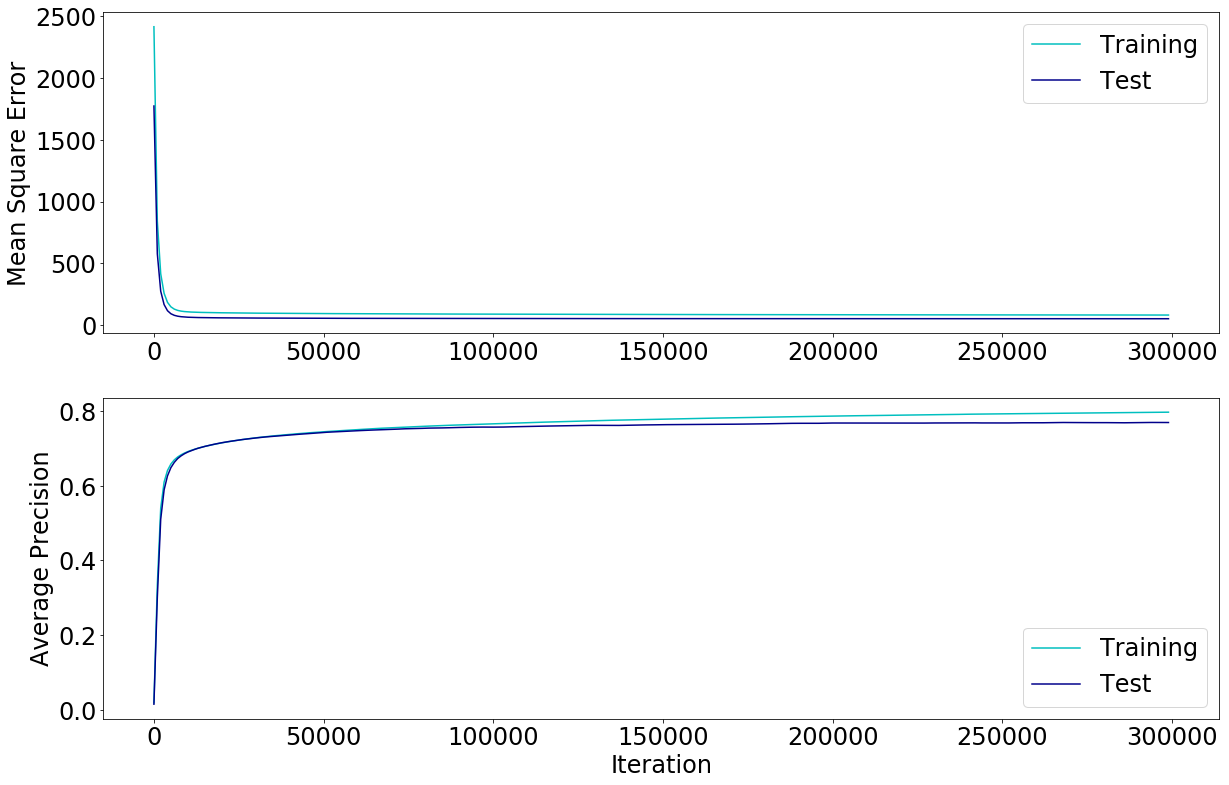

In [70]:
mse_train_res = results_stats['mse_train'][2]
mse_test_res = results_stats['mse_test'][2]

avp_train_res = results_stats['avp_train'][2]
avp_test_res = results_stats['avp_test'][2]

plt.figure(figsize=(width, height))

#plot mean squared error
plt.subplot(2, 1, 1)
#plt.title('Error and Precision',fontsize=fontsize)
plt.plot(iters_res, mse_train_res, label='Training', c="c")
plt.plot(iters_res, mse_test_res, label='Test', c="darkblue")
plt.legend(fontsize=fontsize)
plt.ylabel('Mean Square Error',fontsize=fontsize)

#plot average precision
plt.subplot(2, 1, 2)
plt.plot(iters_res, avp_train_res, label='Training', c="c")
plt.plot(iters_res, avp_test_res, label='Test', c="darkblue")
plt.legend(fontsize=fontsize)
plt.ylabel('Average Precision',fontsize=fontsize)
plt.xlabel('Iteration',fontsize=fontsize)

#plt.savefig('results/plots/'+notebook_reference+'_error_prec.png')

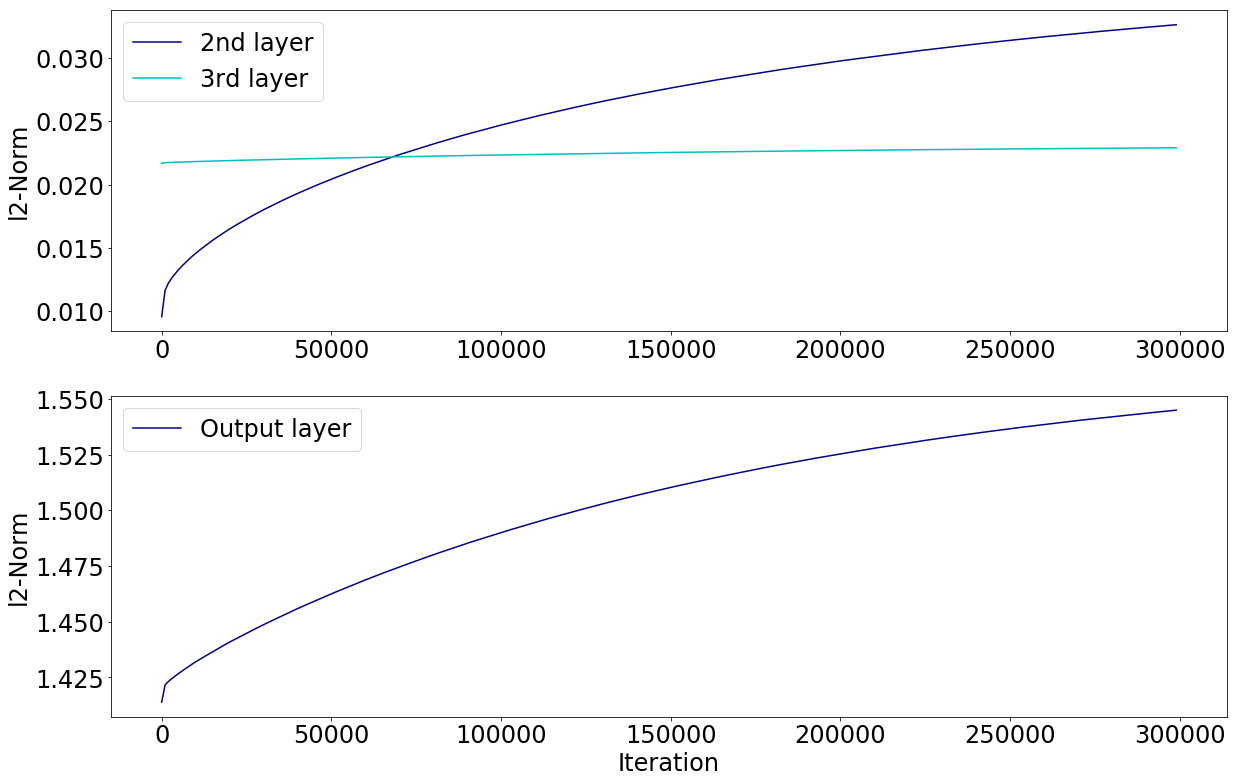

In [71]:
nw = results_stats['nw'][2]
nw2 = results_stats['nw2'][2]
nbeta = results_stats['nbeta'][2]

plt.figure(figsize=(width, height))

plt.subplot(2, 1, 1)
#plt.title('Norm of the Weights of Hidden and Output Layer',fontsize=fontsize)
plt.plot(iters_res, nw, label='2nd layer', c="darkblue")
plt.plot(iters_res, nw2, label='3rd layer', c="c")

plt.legend(fontsize=fontsize)
plt.ylabel('l2-Norm',fontsize=fontsize)

plt.subplot(2, 1, 2)

plt.plot(iters_res, nbeta, label='Output layer', c="darkblue")
plt.legend(fontsize=fontsize)
plt.ylabel('l2-Norm',fontsize=fontsize)
plt.xlabel('Iteration',fontsize=fontsize)

#plt.savefig('results/plots/'+notebook_reference+'_weight_norms.png')

#### 7.2 Mirex Statistics

Statistics that are necesarry for evaluation. The autuor used a threshold of 0.4 for calculation of error etc...

In [72]:
def mirex_statistics(Y, Y_p, threshold=.5, base_note=0, mm=128):
    
    avp = average_precision_score(Y.flatten(), Y_p.flatten())

    # we want zeros and ones
    Yhat_p = Y_p>threshold
    
    # obtain frequencies
    Yp_list = []
    Y_list = []
    
    # for every sample
    for i in range(len(Yhat_p)):
        fhat = []
        f = []
        
        for note in range(mm):
            if Yhat_p[i][note] == 1:
                fhat.append(440.*2**(((note+base_note) - 69.)/12.))
            if Y[i][note] == 1:
                f.append(440.*2**(((note+base_note) - 69.)/12.))

        Yp_list.append(np.array(fhat))
        Y_list.append(np.array(f))

    # Precision, Recall, Accuracy, Substitution, Miss, False Alarm, and Total Error scores 
    # based both on raw frequency values and values mapped to a single octave (chroma)
    
    P,R,Acc,Esub,Emiss,Efa,Etot,cP,cR,cAcc,cEsub,cEmiss,cEfa,cEtot = \
    mir_eval.multipitch.metrics(np.arange(len(Y_list))/100., Y_list,
                                np.arange(len(Yp_list))/100., Yp_list)


    print('{:.2f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}'.format(
        threshold,100*avp,100*P,100*R,Acc,Etot,Esub,Emiss,Efa))

    return avp,P,R,Acc,Etot


In [73]:
tf.reset_default_graph()

num_steps = 300000

# Add ops to save and restore all the variables.
saver = tf.train.Saver({'wavg': wavg, 'w2avg': w2avg, 'betaavg': betaavg})

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session(graph=graph) as sess:
    # Restore variables from disk.
    saver.restore(sess, 'models_'+notebook_reference+'/model-'+str(num_steps-1))
    print("Model restored.")
    # Check the values of the variables

    # A) run model on test set

    # 1. get the test set
    X, Y = get_test_sample(model_stats.test_ids, window, 1000)
    Y = Y[:,base_note:base_note+mm] # in general without effect
    # shape Xtest: (1000*len(test_ids), 1, 16384, 1)
    # shape Ytest: (1000*len(test_ids), 128)
    # extended test-set: 11 samples


    # 2. prediction of output and calculation of
    # - MSE
    # - average precision
    Y_p, mse_test = predict_direct_model(sess, X, Y)


INFO:tensorflow:Restoring parameters from models_190314/model-299999
Model restored.


With the output of the test sample predicted calculate the mirex statistics:

Average Precision (not from mireval), Precision, Recall, Accuracy, Total Error, Substitution, Miss, False Alarm

In [76]:
print('Thr\tAvgP\tP\tR\tAcc\tETot\tESub\tEmiss\tEfa')
for th in [.3, .35,.4, .45, .5]:
    #print("When using threshold",th)
    avp,P,R,Acc,Etot = mirex_statistics(Y, Y_p, th)

Thr	AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
0.30	76.937	66.959	79.091	0.569	0.490	0.109	0.100	0.281
0.35	76.937	69.474	76.076	0.570	0.465	0.108	0.131	0.226
0.40	76.937	71.710	72.898	0.566	0.452	0.106	0.165	0.181
0.45	76.937	73.737	69.821	0.559	0.449	0.102	0.200	0.147
0.50	76.937	75.607	66.512	0.548	0.454	0.095	0.239	0.119
